### Apply ORM with python SQLAlchemy to perform EDA on simulated weather balloon data

#### Assumptions in simulated weather balloon data:
#### - All fields may contain missing data and invalid data, they are defined as NULL in table column
#### - If timestamp is invalid in that single sample, whole row is abandoned. The simulated table would not contain timestamp with NULL value.
#### - We simulate the weather balloon exists exact one in each observatory site, and the location of weather balloon moves around in initial location
#### - The temperature in each observatory site ranges from (-273, 100)


In [1]:
import sqlalchemy
import pandas as pd
import numpy as np
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine


#### 0. Show overview of simulated data

In [2]:
with open("secret.yml", "r") as file:
    connect_str = yaml.safe_load(file)['synpulse']

engine = create_engine(connect_str)

conn = engine.connect()

print("Connected to synpulse database")


Connected to synpulse database


In [26]:
%%time

n_samples = conn.execute(
'''
select count(1)
from weather_main
'''
)

n_samples = n_samples.all()[0]

n_sample = n_samples[0]
print("We totally have {} simulated samples".format(n_sample))


We totally have 500000000 simulated samples
CPU times: user 4.63 ms, sys: 3.25 ms, total: 7.88 ms
Wall time: 1min 53s


In [23]:
%%time

df = pd.read_sql(
 '''
 select time_stamp, latitude, longitude, temperature, country_code from
 weather_main
 order by time_stamp
 limit 10
 ''', conn
)

print("Over view of data:")

df


Over view of data:
CPU times: user 13.5 ms, sys: 1.53 ms, total: 15 ms
Wall time: 1min 58s


,time_stamp,latitude,longitude,temperature,country_code
0,1902-01-01 00:00:00,58.007982,47.543470,-220.868499,LR
1,1902-01-01 00:01:00,55.840886,73.623140,NaN,AM
2,1902-01-01 00:02:00,41.959988,156.484608,-17.037659,UG
3,1902-01-01 00:03:00,12.452897,100.077592,-264.029272,NG
4,1902-01-01 00:04:00,63.480154,116.327372,-80.156508,BE
5,1902-01-01 00:05:00,39.260235,157.720982,-80.023064,MW
6,1902-01-01 00:06:00,72.924220,134.470789,-73.259571,CL
7,1902-01-01 00:07:00,52.804235,108.121082,-51.014848,CA
8,1902-01-01 00:08:00,3.575166,52.539715,-33.862505,KW
9,1902-01-01 00:09:00,20.705421,170.950981,12.808222,AF


#### Observatory is displayed as 'country_code' in the field
#### Location is presented as latitude and longitude field

#### Parse the timestamp contents of the data:

In [22]:
%%time

max_min_time = conn.execute(
'''
select max(time_stamp), min(time_stamp)
from weather_main
'''
)

max_min_time = max_min_time.all()


CPU times: user 8.38 ms, sys: 0 ns, total: 8.38 ms
Wall time: 1min 54s


In [31]:
from datetime import datetime

max_date = max_min_time[0][0]
min_date = max_min_time[0][1]

total_minutes = (max_date - min_date).total_seconds()/60.0 # total minutes, expected number of samples while collect weather by minute

miss_partition = 1 - (n_sample/total_minutes) # proportion of missing timestamp: 1 - exact number of samples/exact time scan in minutes

max_date = datetime.strftime(max_date, "%Y-%m-%d %H:%M:%S")
min_date = datetime.strftime(min_date, "%Y-%m-%d %H:%M:%S")

print("Max date in data:", max_date)
print("Min date in data:", min_date)

print("Proportion {} of the collected data is missing in the simulated data".format(round(miss_partition, 3)))

Max date in data: 2871-09-03 15:59:00
Min date in data: 1902-01-01 00:00:00
Proportion 0.02 of the collected data is missing in the simulated data


#### 1. Parse the missing rate of each fields

In [7]:
%%time
"""
temp_na = conn.execute(
 '''
 select count(1)
 from weather_main
 where temperature is NULL
 '''
)

temp_na = temp_na.all()[0]
"""

print("Temperature missing count:", temp_na[0])

Temperature missing count: 28974581
CPU times: user 59 µs, sys: 35 µs, total: 94 µs
Wall time: 66.5 µs


In [11]:
%%time 

lat_na = conn.execute(
 '''
 select count(1)
 from weather_main
 where latitude is NULL
 '''
)

lat_na = lat_na.all()[0]

print("Latitude missing count:", lat_na[0])


Latitude missing count: 10011020
CPU times: user 4.7 ms, sys: 2.77 ms, total: 7.47 ms
Wall time: 1min 50s


In [12]:
%%time

long_na = conn.execute(
 '''
 select count(1)
 from weather_main
 where longitude is NULL
 '''
)

long_na = long_na.all()[0]

print("Longitude missing count:", long_na[0])


Longitude missing count: 10013210
CPU times: user 3.07 ms, sys: 5.34 ms, total: 8.42 ms
Wall time: 1min 49s


In [10]:
%%time

country_na = conn.execute(
 '''
 select count(1)
 from weather_main
 where country_code is NULL
 '''
)

country_na = country_na.all()[0]

print("Country code missing count:", country_na[0])

Country code missing count: 2490200
CPU times: user 47 µs, sys: 28 µs, total: 75 µs
Wall time: 78.7 µs


In [21]:
# Compare the missing rate of each fields

missing_rate = {"temperature":round(temp_na[0]/n_sample, 3),
               "latitude":round(lat_na[0]/n_sample, 3),
                "longitude":round(long_na[0]/n_sample, 3),
                "country_code":round(country_na[0]/n_sample, 3)
               }



Text(0, 0.5, 'Proportion of missing data (%)')

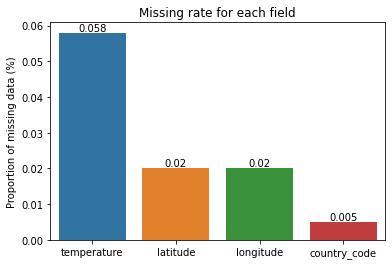

In [28]:
ax = sns.barplot(x= list(missing_rate.keys()), y = list(missing_rate.values()),
                )

ax.bar_label(ax.containers[0])
plt.title("Missing rate for each field")
plt.ylabel("Proportion of missing data (%)")

#### Temperature value has the most percentage of invalid or missing values
#### Location field (latitude, longitude) have similar missing value percentage
#### Country code has the less missing value percentage. The country code is not collected by measurement, instead it is related to the location of the weather balloon.

#### 2. Parse distibutions based on different observatory

In [6]:
%%time

# Display distributions of all weather balloon in each observatory site: 
# Caculate average location for each site

lat_long_mean = conn.execute(
 '''
 select country_code, avg(latitude), avg(longitude)
 from weather_main
 group by country_code;
 '''
)

lat_long_mean = lat_long_mean.all() # [{'country_code', latitude_average, longitude_average}, ...]


CPU times: user 8.89 ms, sys: 0 ns, total: 8.89 ms
Wall time: 2min 15s


In [9]:
print("Preview of average position:")
lat_long_mean[0:5]

Preview of average position:


[('AD', 19.416772035381868, 153.2347530559721),
 ('AE', 44.891656764760064, 42.617164410188394),
 ('AF', 18.462833681972405, 172.98434745692165),
 ('AG', 7.364077985482587, 135.48194946562316),
 ('AI', 25.7850172786105, 20.971769757935764)]

Text(0, 0.5, 'Average longitude')

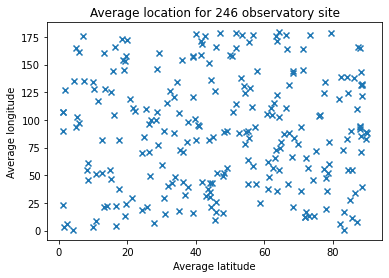

In [14]:

N_SITE = len(lat_long_mean)

lat_pos = list(map(lambda val: val[1], lat_long_mean))
long_pos = list(map(lambda val: val[2], lat_long_mean))

plt.scatter(lat_pos, long_pos, marker="x")
plt.title("Average location for {} observatory site".format(N_SITE))
plt.xlabel("Average latitude")
plt.ylabel("Average longitude")

#### We can see the location of observatory site distributed separately in different places, there is no specific outliers

In [33]:
%%time

# Observe the correlation of location with respect to temperature

lat_long_tmp = conn.execute(
 '''
 select country_code, avg(latitude), avg(longitude), avg(temperature)
 from weather_main
 group by country_code;
 '''
)

lat_long_tmp = lat_long_tmp.all() # [{'country_code', latitude_average, longitude_average}, ...]



CPU times: user 11 ms, sys: 353 µs, total: 11.3 ms
Wall time: 2min 24s


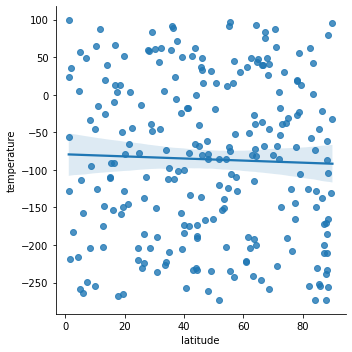

In [36]:
temperature = list(map(lambda val: val[3], lat_long_tmp))

lat_long_temp = pd.DataFrame({"latitude":lat_pos, "temperature":temperature})
sns.lmplot(x="latitude", y="temperature", data=lat_long_temp)

#### There seems to be no clear linear relationship between latitude and temperature, which violate our expectations that as latitude increase, temperature should falls. 
#### However, since we didn't consider the relationship between these two when generating simulation data, this is reasonable.

In [39]:
%%time 

max_min_temp = conn.execute(
 '''
 select max(temperature), min(temperature)
 from weather_main
 '''
)

max_min_temp = max_min_temp.all()

# Show maximum temperature and minimum temperature

print("Maximum temperature in sample:", max(max_min_temp[0]))
print("Minumum temperature in sample:", min(max_min_temp[0]))


Maximum temperature in sample: 99.49981422534472
Minumum temperature in sample: -273.5392268997839
CPU times: user 87 µs, sys: 61 µs, total: 148 µs
Wall time: 124 µs


In [40]:
%%time

# Show variance of temperature in each observatory site

temp_var = conn.execute(
 '''
 select country_code, var_samp(temperature)
 from weather_main
 group by country_code
 '''
)

temp_var = temp_var.all()


CPU times: user 6.7 ms, sys: 4.68 ms, total: 11.4 ms
Wall time: 2min 53s


In [45]:
print("Observatory site and temperature variance:")

temp_var[0:5]


Observatory site and temperature variance:


[('AD', 0.010002589591701338),
 ('AE', 0.009989263780895152),
 ('AF', 0.01001018182691441),
 ('AG', 0.009975917224877897),
 ('AI', 0.009988118964205659)]

Text(0.5, 1.0, 'Temperature variance in each observatory site')

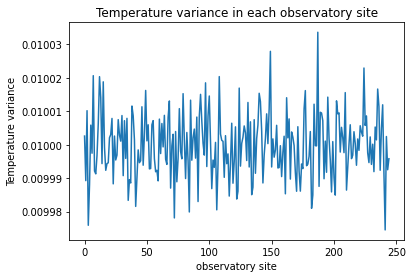

In [66]:
temp_var_val = list(map(lambda val: val[1], temp_var))[:-1]

plt.plot(temp_var_val)
plt.xlabel("observatory site")
plt.ylabel("Temperature variance")
plt.title("Temperature variance in each observatory site")

#### There is no too much variance of temperature variance in each observatory site

In [47]:
%%time

# Show variance of latitude in each site

lat_var = conn.execute(
 '''
 select country_code, var_samp(latitude)
 from weather_main
 group by country_code
 '''
)

lat_var = lat_var.all()

print("Observatory site and latitude variance:")

lat_var[0:5]

Observatory site and latitude variance:
CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 2min 19s


[('AD', 24.990039372858472),
 ('AE', 24.97411675714515),
 ('AF', 25.015564769622067),
 ('AG', 24.999956662183063),
 ('AI', 24.997725727781134)]

Text(0.5, 1.0, 'Latitude variance in each observatory site')

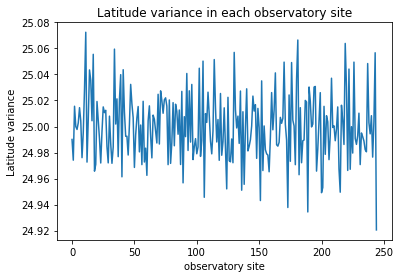

In [68]:
lat_var_val = list(map(lambda val: val[1], lat_var))[:-1]

plt.plot(lat_var_val)
plt.xlabel("observatory site")
plt.ylabel("Latitude variance")
plt.title("Latitude variance in each observatory site")


### We can see that in our simulated data, in each observatory site the temperature and latitude don't vary much.
#### The simulated weather balloon movement oscillated around a fixed area